<a href="https://colab.research.google.com/github/DJS-INFOMATRIX/Computational-Finance-2025-26/blob/main/Project%201%20-%20Indicators/Vatsal_Patel/Indicators_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching data for META...
Fetched 502 days of data
Current closing price: $752.45
Calculating technical indicators...
Training Random Forest model...
Training MSE: 0.000121
Testing MSE: 0.000656
Training R²: 0.793
Testing R²: -0.501

Top 10 Most Important Features:
         feature  importance
3         Volume    0.106679
25   EMA20_trend    0.075618
9           MACD    0.067753
18  Volume_Ratio    0.066606
32     RSI_Lag_2    0.052614
5         SMA_50    0.042497
21    Volatility    0.040307
19  Price_Change    0.037022
14      BB_Width    0.033576
29     RSI_Lag_1    0.029637

Predicting next 3 days...
Day 1: $737.62 (Change: -1.90%)
Day 2: $724.98 (Change: -1.90%)
Day 3: $713.86 (Change: -1.90%)
Creating comprehensive visualization...


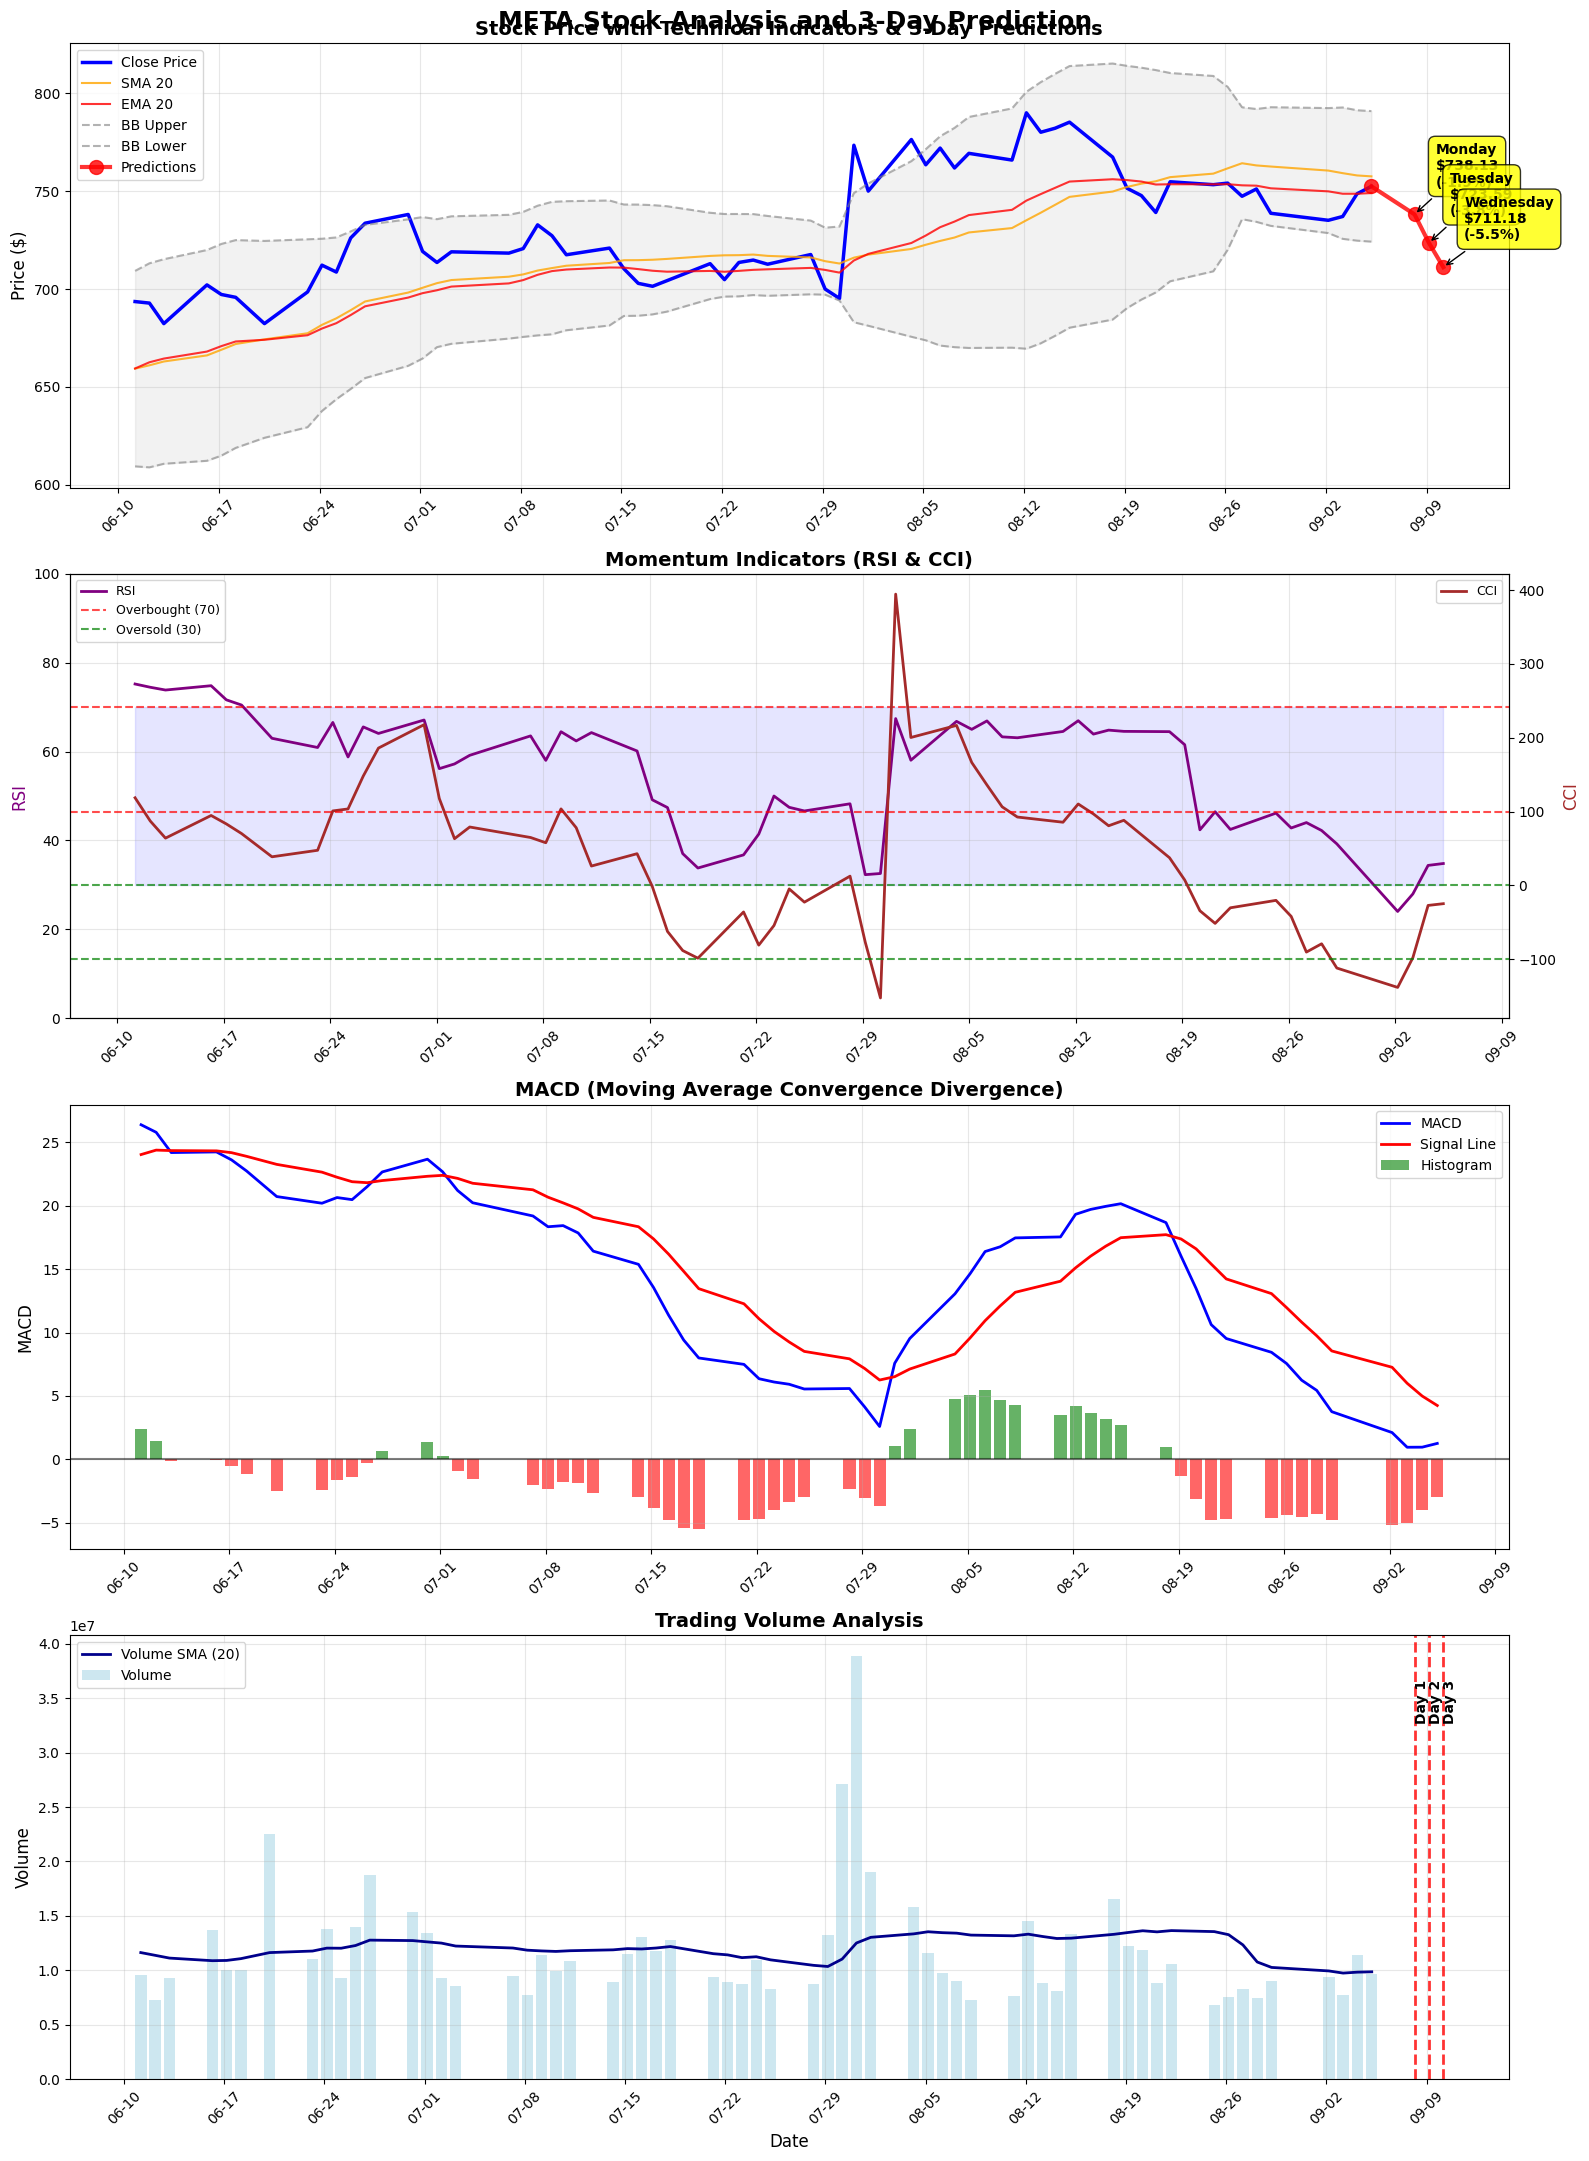


META STOCK PREDICTION SUMMARY
Current Price (Last Close): $752.45
Date: 2025-09-05
------------------------------------------------------------
   Monday: $ 738.13 ( -14.32,   -1.9%) 📉
  Tuesday: $ 723.59 ( -28.86,   -3.8%) 📉
Wednesday: $ 711.18 ( -41.27,   -5.5%) 📉
------------------------------------------------------------
  Average: $ 724.30 ( -28.15,   -3.7%)
3-Day Total Expected Change: -3.7%

CURRENT TECHNICAL INDICATORS
RSI: 34.8 (Neutral)
MACD Signal: Bearish (-2.990)
Bollinger Band Position: 42.4% (Middle Range)


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class MetaStockPredictor:
    def __init__(self):
        self.model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=15, min_samples_split=5)
        self.scaler = StandardScaler()
        self.feature_columns = []

    def fetch_data(self, symbol='META', period='2y'):
        """Fetch stock data from Yahoo Finance"""
        print(f"Fetching data for {symbol}...")
        stock = yf.Ticker(symbol)
        data = stock.history(period=period)
        print(f"Fetched {len(data)} days of data")
        print(f"Current closing price: ${data['Close'].iloc[-1]:.2f}")
        return data

    def calculate_sma(self, data, window=20):
        """Simple Moving Average"""
        return data['Close'].rolling(window=window).mean()

    def calculate_ema(self, data, window=20):
        """Exponential Moving Average"""
        return data['Close'].ewm(span=window).mean()

    def calculate_rsi(self, data, window=14):
        """Relative Strength Index"""
        delta = data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def calculate_macd(self, data, fast=12, slow=26, signal=9):
        """MACD (Moving Average Convergence Divergence)"""
        ema_fast = data['Close'].ewm(span=fast).mean()
        ema_slow = data['Close'].ewm(span=slow).mean()
        macd = ema_fast - ema_slow
        macd_signal = macd.ewm(span=signal).mean()
        macd_histogram = macd - macd_signal
        return macd, macd_signal, macd_histogram

    def calculate_bollinger_bands(self, data, window=20, num_std=2):
        """Bollinger Bands"""
        sma = data['Close'].rolling(window=window).mean()
        std = data['Close'].rolling(window=window).std()
        upper_band = sma + (std * num_std)
        lower_band = sma - (std * num_std)
        bb_width = upper_band - lower_band
        bb_position = (data['Close'] - lower_band) / bb_width
        return upper_band, lower_band, bb_width, bb_position

    def calculate_cci(self, data, window=20):
        """Commodity Channel Index"""
        typical_price = (data['High'] + data['Low'] + data['Close']) / 3
        sma_tp = typical_price.rolling(window=window).mean()
        mad = typical_price.rolling(window=window).apply(lambda x: np.mean(np.abs(x - x.mean())))
        cci = (typical_price - sma_tp) / (0.015 * mad)
        return cci

    def create_features(self, data):
        """Create all technical indicators as features"""
        print("Calculating technical indicators...")

        # Price-based features
        data['SMA_20'] = self.calculate_sma(data, 20)
        data['SMA_50'] = self.calculate_sma(data, 50)
        data['EMA_20'] = self.calculate_ema(data, 20)
        data['EMA_50'] = self.calculate_ema(data, 50)

        # RSI
        data['RSI'] = self.calculate_rsi(data)

        # MACD
        data['MACD'], data['MACD_Signal'], data['MACD_Histogram'] = self.calculate_macd(data)

        # Bollinger Bands
        data['BB_Upper'], data['BB_Lower'], data['BB_Width'], data['BB_Position'] = self.calculate_bollinger_bands(data)

        # CCI
        data['CCI'] = self.calculate_cci(data)

        # Volume indicators
        data['Volume_SMA'] = data['Volume'].rolling(window=20).mean()
        data['Volume_Ratio'] = data['Volume'] / data['Volume_SMA']

        # Price momentum features
        data['Price_Change'] = data['Close'].pct_change()
        data['Price_Change_5d'] = data['Close'].pct_change(periods=5)
        data['Volatility'] = data['Price_Change'].rolling(window=20).std()

        # Price position relative to moving averages
        data['Price_vs_SMA20'] = data['Close'] / data['SMA_20']
        data['Price_vs_EMA20'] = data['Close'] / data['EMA_20']

        # Trend features
        data['SMA20_trend'] = data['SMA_20'].pct_change(periods=5)
        data['EMA20_trend'] = data['EMA_20'].pct_change(periods=5)

        # Support/Resistance levels
        data['High_5d'] = data['High'].rolling(window=5).max()
        data['Low_5d'] = data['Low'].rolling(window=5).min()

        # Lagged features (more recent focus)
        for lag in [1, 2, 3]:
            data[f'Close_Lag_{lag}'] = data['Close'].shift(lag)
            data[f'RSI_Lag_{lag}'] = data['RSI'].shift(lag)
            data[f'MACD_Lag_{lag}'] = data['MACD'].shift(lag)

        return data

    def prepare_training_data(self, data, target_days=1):
        """Prepare features and target for training with percentage change prediction"""
        # Create target variable as percentage change
        data['Target'] = data['Close'].pct_change(periods=target_days).shift(-target_days)

        # Select feature columns
        feature_cols = [
            'Open', 'High', 'Low', 'Volume',
            'SMA_20', 'SMA_50', 'EMA_20', 'EMA_50',
            'RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram',
            'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position',
            'CCI', 'Volume_SMA', 'Volume_Ratio',
            'Price_Change', 'Price_Change_5d', 'Volatility',
            'Price_vs_SMA20', 'Price_vs_EMA20', 'SMA20_trend', 'EMA20_trend',
            'High_5d', 'Low_5d'
        ]

        # Add lagged features
        for lag in [1, 2, 3]:
            feature_cols.extend([f'Close_Lag_{lag}', f'RSI_Lag_{lag}', f'MACD_Lag_{lag}'])

        self.feature_columns = feature_cols

        # Remove rows with NaN values
        clean_data = data[feature_cols + ['Target']].dropna()

        X = clean_data[feature_cols]
        y = clean_data['Target']

        return X, y, clean_data

    def train_model(self, X, y):
        """Train the Random Forest model"""
        print("Training Random Forest model...")

        # Split data (keep temporal order)
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Train model
        self.model.fit(X_train_scaled, y_train)

        # Evaluate model
        train_pred = self.model.predict(X_train_scaled)
        test_pred = self.model.predict(X_test_scaled)

        train_mse = mean_squared_error(y_train, train_pred)
        test_mse = mean_squared_error(y_test, test_pred)
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)

        print(f"Training MSE: {train_mse:.6f}")
        print(f"Testing MSE: {test_mse:.6f}")
        print(f"Training R²: {train_r2:.3f}")
        print(f"Testing R²: {test_r2:.3f}")

        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': self.feature_columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10))

        return X_test, y_test, test_pred

    def predict_next_days(self, data, original_data, days=3):
        """Predict stock prices for the next few days using iterative approach"""
        print(f"\nPredicting next {days} days...")

        predictions = []
        current_price = original_data['Close'].iloc[-1]
        predicted_price = current_price

        # Get the most recent complete row of features
        last_features = data.iloc[-1:][self.feature_columns].copy()

        for day in range(days):
            # Scale features
            features_scaled = self.scaler.transform(last_features.values.reshape(1, -1))

            # Predict percentage change
            pred_pct_change = self.model.predict(features_scaled)[0]

            # Convert to actual price
            predicted_price = predicted_price * (1 + pred_pct_change)
            predictions.append(predicted_price)

            # Add some randomness based on recent volatility for more realistic predictions
            recent_volatility = original_data['Close'].pct_change().tail(20).std()
            noise = np.random.normal(0, recent_volatility * 0.3)
            predicted_price = predicted_price * (1 + noise)

            print(f"Day {day + 1}: ${predicted_price:.2f} (Change: {pred_pct_change*100:+.2f}%)")

        return predictions

    def create_comprehensive_plot(self, clean_data, original_data, predictions, days_to_show=60):
        """Create a comprehensive plot with all indicators and predictions"""
        print("Creating comprehensive visualization...")

        # Get the last N days for plotting from original data
        plot_data = original_data.tail(days_to_show).copy()

        # Create future dates for predictions (skip weekends)
        last_date = plot_data.index[-1]
        future_dates = []
        current_date = last_date
        days_added = 0

        while days_added < len(predictions):
            current_date += timedelta(days=1)
            # Skip weekends (Monday=0, Sunday=6)
            if current_date.weekday() < 5:  # Weekdays only
                future_dates.append(current_date)
                days_added += 1

        # Set up the plot with subplots
        fig, axes = plt.subplots(4, 1, figsize=(16, 22))
        fig.suptitle('META Stock Analysis and 3-Day Prediction', fontsize=18, fontweight='bold')

        # Plot 1: Price, Moving Averages, Bollinger Bands, and Predictions
        ax1 = axes[0]
        ax1.plot(plot_data.index, plot_data['Close'], label='Close Price', color='blue', linewidth=2.5)
        ax1.plot(plot_data.index, plot_data['SMA_20'], label='SMA 20', color='orange', alpha=0.8, linewidth=1.5)
        ax1.plot(plot_data.index, plot_data['EMA_20'], label='EMA 20', color='red', alpha=0.8, linewidth=1.5)
        ax1.plot(plot_data.index, plot_data['BB_Upper'], label='BB Upper', color='gray', linestyle='--', alpha=0.6)
        ax1.plot(plot_data.index, plot_data['BB_Lower'], label='BB Lower', color='gray', linestyle='--', alpha=0.6)
        ax1.fill_between(plot_data.index, plot_data['BB_Upper'], plot_data['BB_Lower'], alpha=0.1, color='gray')

        # Add predictions with connecting line
        last_price = plot_data['Close'].iloc[-1]
        all_dates = list(plot_data.index[-1:]) + future_dates
        all_prices = [last_price] + predictions
        ax1.plot(all_dates, all_prices, 'ro-', label='Predictions', markersize=10, linewidth=3, alpha=0.8)

        # Add day labels for predictions
        day_labels = ['Monday', 'Tuesday', 'Wednesday']
        for i, (date, pred, label) in enumerate(zip(future_dates, predictions, day_labels)):
            change = (pred - last_price) / last_price * 100
            ax1.annotate(f'{label}\n${pred:.2f}\n({change:+.1f}%)',
                        xy=(date, pred),
                        xytext=(15, 20),
                        textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
                        fontsize=10, fontweight='bold',
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

        ax1.set_title('Stock Price with Technical Indicators & 3-Day Predictions', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Price ($)', fontsize=12)
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)

        # Plot 2: RSI and CCI
        ax2 = axes[1]
        ax2_twin = ax2.twinx()

        # RSI
        ax2.plot(plot_data.index, plot_data['RSI'], label='RSI', color='purple', linewidth=2)
        ax2.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
        ax2.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
        ax2.fill_between(plot_data.index, 30, 70, alpha=0.1, color='blue')
        ax2.set_ylabel('RSI', color='purple', fontsize=12)
        ax2.set_ylim(0, 100)
        ax2.legend(loc='upper left', fontsize=9)

        # CCI
        ax2_twin.plot(plot_data.index, plot_data['CCI'], label='CCI', color='brown', linewidth=2)
        ax2_twin.axhline(y=100, color='red', linestyle='--', alpha=0.7)
        ax2_twin.axhline(y=-100, color='green', linestyle='--', alpha=0.7)
        ax2_twin.set_ylabel('CCI', color='brown', fontsize=12)
        ax2_twin.legend(loc='upper right', fontsize=9)

        ax2.set_title('Momentum Indicators (RSI & CCI)', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)

        # Plot 3: MACD
        ax3 = axes[2]
        ax3.plot(plot_data.index, plot_data['MACD'], label='MACD', color='blue', linewidth=2)
        ax3.plot(plot_data.index, plot_data['MACD_Signal'], label='Signal Line', color='red', linewidth=2)

        # Color-coded histogram
        colors = ['red' if x < 0 else 'green' for x in plot_data['MACD_Histogram']]
        ax3.bar(plot_data.index, plot_data['MACD_Histogram'], label='Histogram', alpha=0.6, color=colors)
        ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)

        ax3.set_title('MACD (Moving Average Convergence Divergence)', fontsize=14, fontweight='bold')
        ax3.set_ylabel('MACD', fontsize=12)
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)

        # Plot 4: Volume Analysis
        ax4 = axes[3]
        ax4.bar(plot_data.index, plot_data['Volume'], alpha=0.6, color='lightblue', label='Volume')
        ax4.plot(plot_data.index, plot_data['Volume_SMA'], color='darkblue', linewidth=2, label='Volume SMA (20)')

        # Add vertical lines for prediction days
        for i, date in enumerate(future_dates):
            ax4.axvline(x=date, color='red', linestyle='--', alpha=0.8, linewidth=2)
            ax4.text(date, ax4.get_ylim()[1]*0.9, f'Day {i+1}', rotation=90,
                    verticalalignment='top', fontsize=10, fontweight='bold')

        ax4.set_title('Trading Volume Analysis', fontsize=14, fontweight='bold')
        ax4.set_ylabel('Volume', fontsize=12)
        ax4.set_xlabel('Date', fontsize=12)
        ax4.legend(fontsize=10)
        ax4.grid(True, alpha=0.3)

        # Format x-axis for all subplots
        for ax in axes:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

        plt.tight_layout()
        plt.show()

        # Print detailed summary
        print(f"\n" + "="*60)
        print("META STOCK PREDICTION SUMMARY")
        print("="*60)
        current_price = original_data['Close'].iloc[-1]
        print(f"Current Price (Last Close): ${current_price:.2f}")
        print(f"Date: {original_data.index[-1].strftime('%Y-%m-%d')}")
        print("-" * 60)

        day_names = ['Monday', 'Tuesday', 'Wednesday']
        total_change = 0
        for i, (day, pred) in enumerate(zip(day_names, predictions)):
            change = pred - current_price
            change_pct = (change / current_price) * 100
            total_change += change_pct
            direction = "📈" if change > 0 else "📉" if change < 0 else "➡️"
            print(f"{day:>9}: ${pred:>7.2f} ({change:>+7.2f}, {change_pct:>+6.1f}%) {direction}")

        avg_prediction = np.mean(predictions)
        avg_change = avg_prediction - current_price
        avg_change_pct = (avg_change / current_price) * 100

        print("-" * 60)
        print(f"{'Average':>9}: ${avg_prediction:>7.2f} ({avg_change:>+7.2f}, {avg_change_pct:>+6.1f}%)")
        print(f"3-Day Total Expected Change: {total_change/3:+.1f}%")

        # Technical analysis summary
        latest_rsi = original_data['RSI'].iloc[-1]
        latest_macd = original_data['MACD'].iloc[-1] - original_data['MACD_Signal'].iloc[-1]
        latest_bb_pos = original_data['BB_Position'].iloc[-1]

        print("\n" + "="*60)
        print("CURRENT TECHNICAL INDICATORS")
        print("="*60)
        print(f"RSI: {latest_rsi:.1f} ({'Overbought' if latest_rsi > 70 else 'Oversold' if latest_rsi < 30 else 'Neutral'})")
        print(f"MACD Signal: {'Bullish' if latest_macd > 0 else 'Bearish'} ({latest_macd:.3f})")
        print(f"Bollinger Band Position: {latest_bb_pos:.1%} ({'Upper Band' if latest_bb_pos > 0.8 else 'Lower Band' if latest_bb_pos < 0.2 else 'Middle Range'})")

def main():
    # Initialize predictor
    predictor = MetaStockPredictor()

    # Fetch and prepare data
    original_data = predictor.fetch_data('META', '2y')
    data_with_features = predictor.create_features(original_data.copy())

    # Prepare training data
    X, y, clean_data = predictor.prepare_training_data(data_with_features)

    # Train model
    X_test, y_test, test_pred = predictor.train_model(X, y)

    # Make predictions for next 3 days
    predictions = predictor.predict_next_days(clean_data, data_with_features, days=3)

    # Create comprehensive visualization
    predictor.create_comprehensive_plot(clean_data, data_with_features, predictions, days_to_show=60)

if __name__ == "__main__":
    main()